This section is for the inference into the bayesian network. I tried ti implement the Gibbs samlping method to infer into our bayesian network.

In [ ]:
# This cell needs to be executed, before running the program, to make sure your system is up and running with the Python Pomegranate Package.
# Need to install pomegranate to have the facilty of implementing the Bayesian network
# Then matplotlib and pygraphviz packages too [For the diagram / graph / plotting purposes]
!pip install pomegranate
!pip install matplotlib
!apt-get install -y graphviz-dev
!pip install pygraphviz

In [ ]:
# We need pomegranate for the bayesian model
# we need numpy for mathemetiacal purposes
# so we imported both those packages
from pomegranate import *
import numpy as np
# probability for Owning A Device
owns_device = DiscreteDistribution({'T': 0.7, 'F': 0.3})
# probability for Travelling
travel = DiscreteDistribution({'T': 0.05, 'F': 0.95})
# CPT for the foreign purchase given the travel information
foreign_purchase = ConditionalProbabilityTable(
        [['T', 'T', 0.88],
         ['T', 'F', 0.0001],
         ['F', 'T', 0.12],
         ['F', 'F', 0.995]], [travel])
# CPT for online purchase given the information of owning a device
online_purchase = ConditionalProbabilityTable(
        [['T', 'T', 0.4],
         ['T', 'F', 0.05],
         ['F', 'T', 0.6],
         ['F', 'F', 0.95]], [owns_device])
# CPT for fraud given information of both travelling and online purchase
fraud = ConditionalProbabilityTable(
        [['T', 'T', 'T', 0.995],
         ['T', 'T', 'F', 0.8],
         ['T', 'F', 'T', 0.85],
         ['T', 'F', 'F', 0.75],
         ['F', 'T', 'T', 0.005],
         ['F', 'T', 'F', 0.2],
         ['F', 'F', 'T', 0.15],
         ['F', 'F', 'F', 0.25]], [online_purchase, travel])

# Creating node based on the variables
OD = Node(owns_device, name="Owns Device")
T = Node(travel, name="Travelling")
FP = Node(foreign_purchase, name="Foreign Purchase")
OP = Node(online_purchase, name="Online Purchase")
F = Node(fraud, name="Fraud")
# Constructing the bayesian network, with the dependencies and CPT's
model = BayesianNetwork("Credit Card Fraud System")
model.add_states(OD, T, FP, OP, F)
model.add_edge(OD, OP)
model.add_edge(OP, F)
model.add_edge(T, F)
model.add_edge(T, FP)

#Locking the network or the syatem
model.bake()

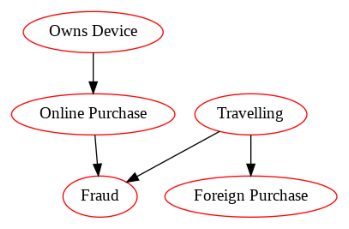

In [4]:
# Plot the graph for visualization
model.plot()

In [49]:
# maximum number of iteration for the gibbs sampling
max_iteration = 10000000

In [29]:
# this section is to calculate the joint distribution of all varibales, for all possible combinations
# as there are 5 variables, and each having 2 (true/false) instances, we will have total 32 combinations
def get_joint_distribution():  
  joint_distribution = [[[[[0.0 for _ in range(2)] for _ in range(2)] for _ in range(2)] for _ in range(2)] for _ in range(2)]
  for i in range (2):
    if(i == 0):
      OD = 'F'
    else:
      OD = 'T'
    for j in range (2):
      if(j == 0):
        T = 'F'
      else:
        T = 'T'
      for k in range (2):
        if(k == 0):
          FP = 'F'
        else:
          FP = 'T'
        for l in range (2):
          if(l == 0):
            OP = 'F'
          else:
            OP = 'T'
          for m in range (2):
            if(m == 0):
              F = 'F'
            else:
              F = 'T'
            joint_distribution[i][j][k][l][m] = model.probability([[OD, T, FP, OP, F]])
            #print(joint_distribution[i][j][k][l][m])
  return (joint_distribution)




Steps follwed in Gibbs Sampling :-
1. Fix the evidence variable instances
2. assign true/false randomly to the other variables
3. select any one variable randomly apart from evidence
4. sample that varible given its markov blanket and evidence
5. identify whether the sampling result in true/false
6. select randomly apart from evidence and sample on the variable considering evidence, markov blanket and result from previous sample
7. repeat from step 5 around 10000 times
8. calculate probability from the samples

In [43]:
# This function helps us sample a variable given all evidences and markov blanket of the variable
def conditional_sampler(var, cur_sample):
  global joint_distribution
  if(var == 0):
    probability = joint_distribution[1][cur_sample[1]][cur_sample[2]][cur_sample[3]][cur_sample[4]]
    comp_probability = joint_distribution[0][cur_sample[1]][cur_sample[2]][cur_sample[3]][cur_sample[4]]
  elif(var == 1):
    probability = joint_distribution[cur_sample[0]][1][cur_sample[2]][cur_sample[3]][cur_sample[4]]
    comp_probability = joint_distribution[cur_sample[0]][0][cur_sample[2]][cur_sample[3]][cur_sample[4]]
  elif(var == 2):
    probability = joint_distribution[cur_sample[0]][cur_sample[1]][1][cur_sample[3]][cur_sample[4]]
    comp_probability = joint_distribution[cur_sample[0]][cur_sample[1]][0][cur_sample[3]][cur_sample[4]]
  elif(var == 3):
    probability = joint_distribution[cur_sample[0]][cur_sample[1]][cur_sample[2]][1][cur_sample[4]]
    comp_probability = joint_distribution[cur_sample[0]][cur_sample[1]][cur_sample[2]][0][cur_sample[4]]
  elif(var == 4):
    probability = joint_distribution[cur_sample[0]][cur_sample[1]][cur_sample[2]][cur_sample[3]][1]
    comp_probability = joint_distribution[cur_sample[0]][cur_sample[1]][cur_sample[2]][cur_sample[3]][0]
  probability /= (probability + comp_probability)
  if np.random.rand() <= probability:
    return 1
  else:
    return 0

In [46]:
# This function implments gibbs sampling given the state variable and evidence variables
def gibbs_sampling(variable, value, evidence_dict):
  global max_iteration
  global test
  no_of_var = 5
  sample = [None] * no_of_var
  for i in range(no_of_var):
    if i in evidence_dict.keys():
      sample[i] = evidence_dict[i]
    elif np.random.rand() >= 0.5:
      sample[i] = 1
    else:
      sample[i] = 0
  count = 0
  #loop_count = 0
  for t in range(1, max_iteration):
    for i in range(no_of_var):
      if i not in evidence_dict.keys():
        if i == variable:
          test[sample[0]][sample[1]][sample[2]][sample[3]] += 1
          if conditional_sampler(i, sample) == value:
            count += 1;
            sample[i] = value;
          else:
            sample[i] = 1 - value;
        else:
          sample[i] = conditional_sampler(i, sample)
        #loop_count += 1
  #print(loop_count)
  return (count / max_iteration)

In [ ]:
print("Enter the number of queries : ", end = "")
queries = int(input())
joint_distribution = get_joint_distribution()
test = [[[[0] * 2 for _ in range(2)] for _ in range(2)] for _ in range(2)]
for _ in range (queries):
  print("We have the variables :-")
  print("1. owns_device")
  print("2. travel")
  print("3. foreign_purchase")
  print("4. online_purchase")
  print("5. fraud")
  print("Enter the variable number (1 to 5 : as mentioned above) and the instance (0 for false, 1 for true) you want to compute the probability :-")
  tar_variable, tar_instance = [int(x) for x in (input().split())]
  print("Enter the number of evidence variables : ", end = "")
  var = int(input())
  our_evidence_dict = {}
  if(var != 0):
    print("Enter the variable number (as mentioned above) and instance (0 for false, 1 for true) :-");
  for _ in range (var):
    variable, instance = [int(x) for x in (input().split())]
    our_evidence_dict[variable - 1] = instance
  req_probability = gibbs_sampling(tar_variable - 1, tar_instance, our_evidence_dict)
  for i in range(2):
    for j in range(2):
      for k in range(2):
        for l in range(2):
          #print(test[i][j][k][l], end = " ")
  print(req_probability)